In [1]:
#source https://github.com/jamalsenouci/causalimpact/blob/3110a20dde1c4e5694bbb05bb304a3ec1f97dc31/GettingStarted.ipynb

In [2]:

from causalimpact import CausalImpact

Let'say we want to see the effect of shutting down SEA on the combined SEA+SEO revenue.

The challenge is to construct the counterfactual i.e the unobserved data, (what would have happened if we didn't shut down SEA).

A powerful approach is to create a synthetic control group. There are 3 sources of information available for constructing an adequate synthetic control group:
1) The times-series prior to the intervention (the SEA shut down)
2) The times-series similar to number 1 prior to the intervention. So for example, the revenue of a similar campaign in another country that did not receive the intervention or a metric that reflects te activity as a whole. The challenge is here to pick the correct one. This means we assume time-series 1 and 2 would have had the same behaviour had not been an intervention
3) The available prior knowledge about the model parameters

These 3 sources of information are combined using a state-space time-series model

### Import and generate artificial data

In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_process import arma_generate_sample
import matplotlib
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15, 6)

np.random.seed(1)

x1 = arma_generate_sample(ar=[0.999], ma=[0.9], nsample=100) + 100
y = 1.2 * x1 + np.random.randn(100)

y[71:100] = y[71:100] + 10
data = pd.DataFrame(np.array([y, x1]).T, columns=["y","x1"])

In [4]:
data.head()

,y,x1
0,121.308920,101.463374
1,120.563149,99.448868
2,119.832495,99.524170
3,119.433612,99.033362
4,119.840664,100.779647


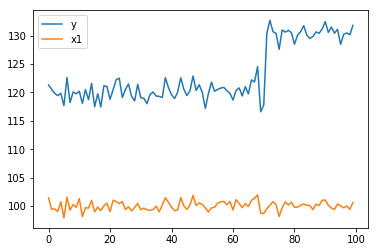

In [6]:
data.plot();

### Running Analysis
To estimate the causal effect, we begin by specifying which period in the data should be used for training the model (pre-intervention period) and which period for computing a counterfactual prediction (post-intervention period).

In [8]:

pre_period = [0,69]
post_period = [71,99]

This says that time points 0...70 will be used for training, and time points 71...99 will be used for computing predictions. Alternatively, we could specify the periods in terms of dates or time points; see Section 5 for an example.

To perform inference, we run the analysis using:

In [14]:
impact = CausalImpact(data, pre_period, post_period)

This initialises a CausalImpact object

In [15]:
impact.run()

This instructs the package to assemble a structural time-series model, fit the model using MLE by default, and compute estimates of the causal effect. We can view the results in a dataframe as follows:

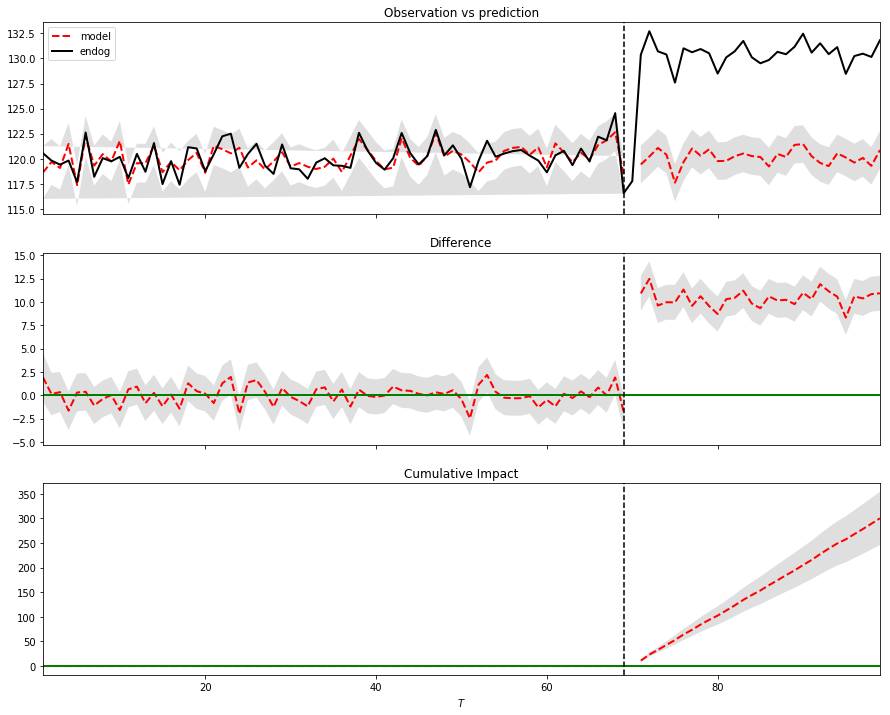

In [17]:
impact.plot()

By default, the plot contains three panels. 

(1) The first panel shows the data and a counterfactual prediction for the post-treatment period. 

(2) The second panel shows the difference between observed data and counterfactual predictions. This is the pointwise causal effect, as estimated by the model. In other words, the difference between the obsevred series and the series that would have been observed had the intervantion not taken place

(3) The third panel adds up the pointwise contributions from the second panel, resulting in a plot of the cumulative effect of the intervention.

Remember, once again, that all of the above inferences depend critically on the assumption that the covariates were not themselves affected by the intervention. The model also assumes that the relationship between covariates and treated time series, as established during the pre-period, remains stable throughout the post-period.

### Working with dates and times
It is often more natural to feed a time-series object into CausalImpact() rather than a data frame. For example, we might create a data variable as follows:

In [20]:
date_range = pd.date_range(start="2014-01-01", periods=100)
data.index = date_range
data.head()

,y,x1
2014-01-01,121.308920,101.463374
2014-01-02,120.563149,99.448868
2014-01-03,119.832495,99.524170
2014-01-04,119.433612,99.033362
2014-01-05,119.840664,100.779647


We can now specify the pre_period and post_period in terms of time points rather than indices:

In [21]:
pre_period = [pd.to_datetime(date) for date in ["2014-01-01", "2014-03-12"]]
post_period = [pd.to_datetime(date) for date in ["2014-03-13", "2014-04-10"]]

As a result, the x-axis of the plot shows time points instead of indices:

In [22]:
impact = CausalImpact(data, pre_period, post_period)
impact.run()

In [23]:
impact.inferences.head(5)

,response,cum_response,point_pred,point_pred_lower,point_pred_upper,cum_pred,cum_pred_lower,cum_pred_upper,point_effect,point_effect_lower,point_effect_upper,cum_effect,cum_effect_lower,cum_effect_upper
2014-01-01,121.308920,121.308920,121.994854,-2804.815502,3048.805211,121.994854,-2804.815502,3048.805211,-0.685934,2926.124423,-2927.496290,0.0,0.0,0.0
2014-01-02,120.563149,241.872070,118.618185,116.007655,121.228715,240.613039,-2688.807847,3170.033926,1.944964,4.555494,-0.665566,0.0,0.0,0.0
2014-01-03,119.832495,361.704565,119.691246,117.430460,121.952031,360.304285,-2571.377387,3291.985957,0.141249,2.402035,-2.119536,0.0,0.0,0.0
2014-01-04,119.433612,481.138177,119.082766,116.951277,121.214255,479.387051,-2454.426110,3413.200212,0.350846,2.482335,-1.780643,0.0,0.0,0.0
2014-01-05,119.840664,600.978841,121.502956,119.439151,123.566761,600.890007,-2334.986959,3536.766973,-1.662292,0.401513,-3.726097,0.0,0.0,0.0


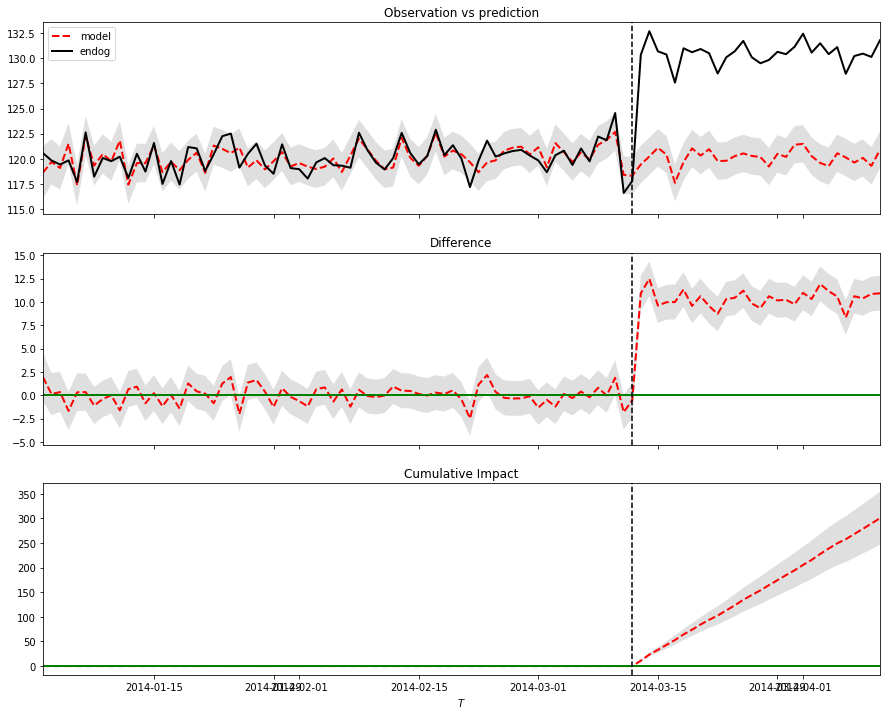

In [24]:
impact.plot()

### Summary Table

In [25]:
impact.summary()

                              Average     Cumulative
Actual                            130           3784
Predicted                         120           3484
95% CI                     [118, 122]   [3430, 3538]
                                                    
Absolute Effect                    10            300
95% CI                        [12, 8]     [354, 246]
                                                    
Relative Effect                  8.6%           8.6%
95% CI                  [10.2%, 7.1%]  [10.2%, 7.1%]
                                                    
P-value                          0.0%               
Prob. of Causal Effect         100.0%               


he Average column talks about the average (across time) during the post-intervention period (in the example: time points 71 through 100). The Cumulative column sums up individual time points, which is a useful perspective if the response variable represents a flow quantity (such as queries, clicks, visits, installs, sales, or revenue) rather than a stock quantity (such as number of users or stock price).

In the example, the estimated average causal effect of treatment was 11 (rounded to a whole number; for full precision see impact$summary). This is because we observed an average value of 99 but would have expected an average value of only 89. The 95% posterior interval of the average effect is [9.8, 11]. Since this excludes 0, we (correctly) conclude that the intervention had a causal effect on the response variable. Since we generated the data ourselves, we know that we injected a true effect of 10, and so the model accurately recovered ground truth. One reason for this is that we ensured, by design, that the covariate x1 was not itself affected by the intervention. In practice, we must always reason whether this assumption is justified.

For additional guidance about the correct interpretation of the summary table, the package provides a verbal interpretation, which we can print using:

In [26]:
impact.summary("report")

 During the post-intervention period, the response variable had an average value of approx. 130.  By contrast, in  the
absence of an intervention, we would have expected an average response of 120. The 95% interval of this counterfactual
prediction is [118, 122]. Subtracting this prediction from the observed response yields an estimate of the causal effect
the intervention had on the response variable. This effect is 10 with a 95% interval of [12, 8]. For a discussion of the
significance of this effect, see below.


 Summing up the individual data points during the post-intervention period (which can only sometimes be meaningfully
interpreted), the response variable had an overall value of 3784.  By contrast, had  the intervention not taken place,
we would have expected a sum of 3784. The 95% interval of this prediction is [3430, 3538]


 The above results are given in terms of absolute numbers. In relative terms, the response variable showed  an increase
of  8.6%. The 95% interval of 

### Adjusting the model
So far, we've simply let the package decide how to construct a time-series model for the available data. However, there are several options that allow us to gain a little more control over this process. These options are passed into model_args as individual list elements, for example:

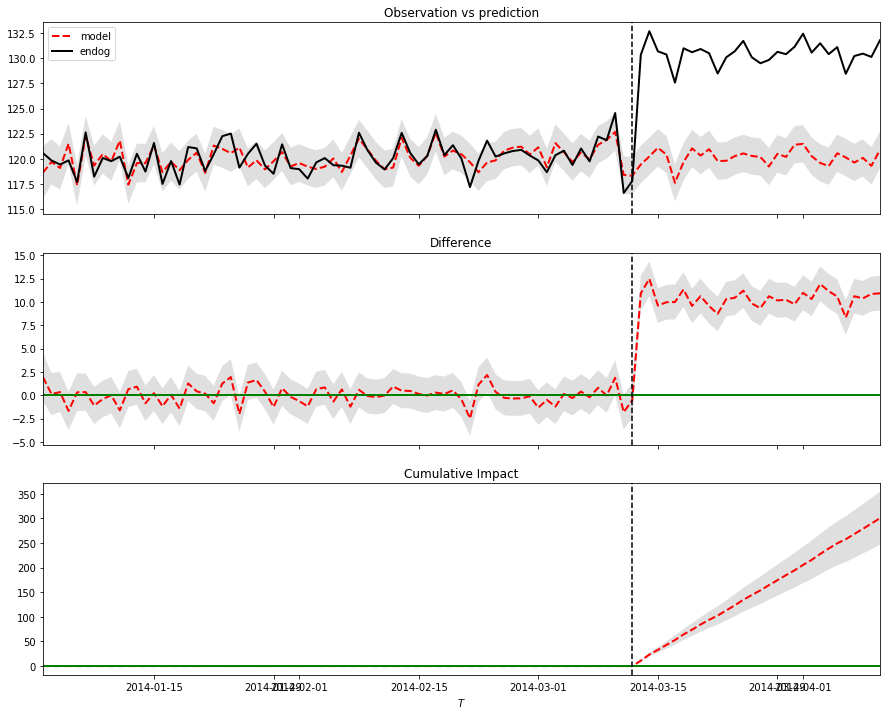

In [27]:
impact = CausalImpact(data, pre_period, post_period, model_args={"niter":5000, "nseasons":7})
impact.run()
impact.plot()

Available options
niter Number of MCMC samples to draw. More samples lead to more accurate inferences. Defaults to 1000.

standardize_data Whether to standardize all columns of the data before fitting the model. This is equivalent to an empirical Bayes approach to setting the priors. It ensures that results are invariant to linear transformations of the data. Defaults to TRUE.

prior_level_sd Prior standard deviation of the Gaussian random walk of the local level. Expressed in terms of data standard deviations. Defaults to 0.01, a typical choice for well-behaved and stable datasets with low residual volatility after regressing out known predictors (e.g., web searches or sales in high quantities). When in doubt, a safer option is to use 0.1, as validated on synthetic data, although this may sometimes give rise to unrealistically wide prediction intervals.

nseasons Period of the seasonal components. In order to include a seasonal component, set this to a whole number greater than 1. For example, if the data represent daily observations, use 7 for a day-of-week component. This interface currently only supports up to one seasonal component. To specify multiple seasonal components, use bsts to specify the model directly, then pass the fitted model in as bsts.model. Defaults to 1, which means no seasonal component is used.

season_duration Duration of each season, i.e., number of data points each season spans. Defaults to 1. For example, to add a day-of-week component to data with daily granularity, use model_args = list(nseasons = 7, season_duration = 1). To add a day-of-week component to data with hourly granularity, set model_args = list(nseasons = 7, season_duration = 24).

dynamic_regression Whether to include time-varying regression coefficients. In combination with a time-varying local trend or even a time-varying local level, this often leads to overspecification, in which case a static regression is safer. Defaults to FALSE.

### Using a custom model
Instead of using the default model constructed by the CausalImpact package, we can use the bsts package to specify our own model. This provides the greatest degree of flexibility.

Before constructing a custom model, we set the observed data in the post-treatment period to NA, reflecting the fact that the counterfactual response is unobserved after the intervention. We keep a copy of the actual observed response in the variable post_period_response.

In [28]:
post_period = [70,100]
post_period_response = y[post_period[0]:post_period[1]].copy()
y[post_period[0]:post_period[1]] = np.nan

We next set up and estimate a time series model using the statsmodels package. Here is a simple example:

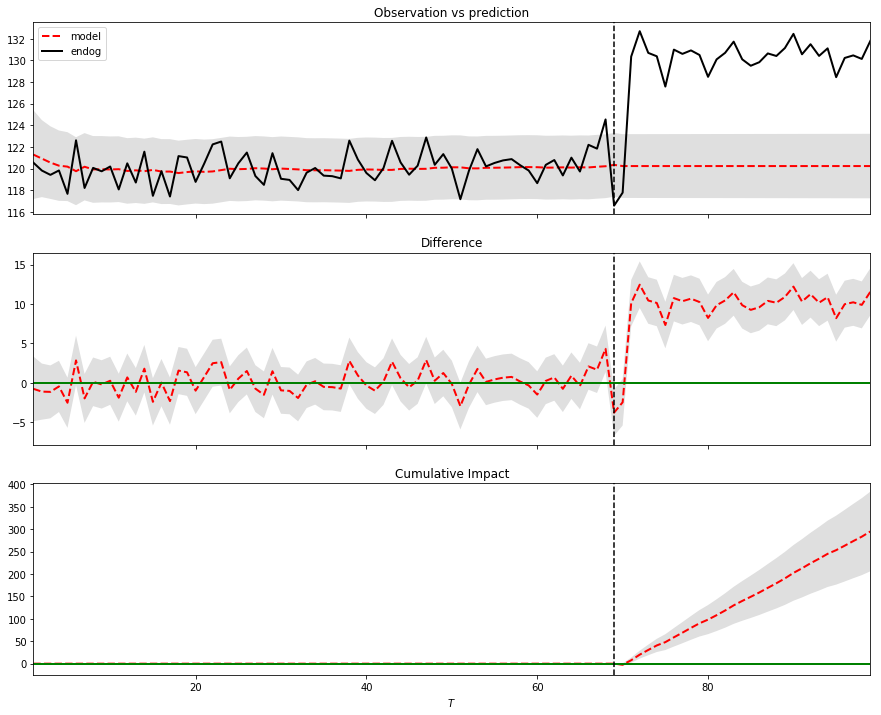

In [29]:
from statsmodels.tsa.statespace.structural import UnobservedComponents
ucm_model = UnobservedComponents(endog=y, level="llevel")
impact = CausalImpact(ucm_model=ucm_model, post_period_response=post_period_response)
impact.run()
#TODO
impact.plot()

In [30]:
impact.inferences

,response,cum_response,point_pred,point_pred_lower,point_pred_upper,cum_pred,cum_pred_lower,cum_pred_upper,point_effect,point_effect_lower,point_effect_upper,cum_effect,cum_effect_lower,cum_effect_upper
0,121.308920,121.308920,0.000000,-1959.966134,1959.966134,0.000000,-1959.966134,1959.966134,121.308920,2081.275055,-1838.657214,0.000000,0.000000,0.000000
1,120.563149,241.872070,121.308654,117.202395,125.414913,121.308654,-1842.763739,2085.381048,-0.745505,3.360754,-4.851764,0.000000,0.000000,0.000000
2,119.832495,361.704565,120.935753,117.379151,124.492354,242.244407,-1725.384588,2209.873402,-1.103257,2.453344,-4.659859,0.000000,0.000000,0.000000
3,119.433612,481.138177,120.567508,117.213863,123.921153,362.811915,-1608.170725,2333.794555,-1.133896,2.219749,-4.487541,0.000000,0.000000,0.000000
4,119.840664,600.978841,120.283238,117.035651,123.530825,483.095153,-1491.135074,2457.325380,-0.442574,2.805013,-3.690161,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,128.456173,11789.191224,120.247410,117.272830,123.221990,11407.920427,9163.268390,13652.572464,8.208762,11.183342,5.234182,253.334535,330.302434,176.366636
96,130.230586,11919.421810,120.247410,117.271692,123.223129,11528.167837,9280.540082,13775.795592,9.983175,12.958893,7.007457,263.317710,343.261327,183.374093
97,130.467414,12049.889223,120.247410,117.270555,123.224266,11648.415248,9397.810637,13899.019859,10.220003,13.196859,7.243148,273.537714,356.458186,190.617241
98,130.140680,12180.029904,120.247410,117.269417,123.225404,11768.662658,9515.080054,14022.245262,9.893270,12.871263,6.915277,283.430984,369.329449,197.532518


Finally, we call CausalImpact(). Instead of providing input data, we simply pass in the fitted model object (bsts_model). We also need to provide the actual observed response. This is needed so that the package can compute the difference between predicted response (stored in bsts_model) and actual observed response (stored in post_period_response).

### FAQ

### How do I cite the package in my work?

We recommend referencing the use of the CausalImpact R package as shown in the example below:

"CausalImpact r packageVersion("CausalImpact"), Brodersen et al., Annals of Applied Statistics (2015). http://google.github.io/CausalImpact/"

To find out which package version you are using, type import causalimpact; causalimpact.__version__. See the bottom of this page for full bibliographic details.

## How can I check whether the model assumptions are fulfilled?
It's the elephant in the room with any causal analysis on observational data: how can we verify the assumptions that go into the model? Here are a few ways of getting started. First of all, it is critical to reason why the covariates that are included in the model (this was x1 in the example) were not themselves affected by the intervention. Sometimes it helps to plot all covariates and do a visual sanity check. Next, it is a good idea to examine how well the outcome data y can be predicted before the beginning of the intervention. This can be done by running CausalImpact() on an imaginary intervention. Then check how well the model predicted the data following this imaginary intervention. We would expect not to find a significant effect, i.e., counterfactual estimates and actual data should agree reasonably closely. Finally, when presenting or writing up results, be sure to list the above assumptions explicitly, including the priors in model_args, and discuss them with your audience.

### May the data contain missing values?
The response variable (i.e., the first column in data) may contain missing values (NA), but covariates (all other columns in data) may not. If one of your covariates contains missing values, consider imputing (i.e., estimating) the missing values; if this is not feasible, leave the regressor out.

### How can I customize the default plot?¶
By default, impact.plot() creates three panels, showing the counterfactual, pointwise, and cumulative impact estimates. One way of customizing the plot is to specify which panels should be included:

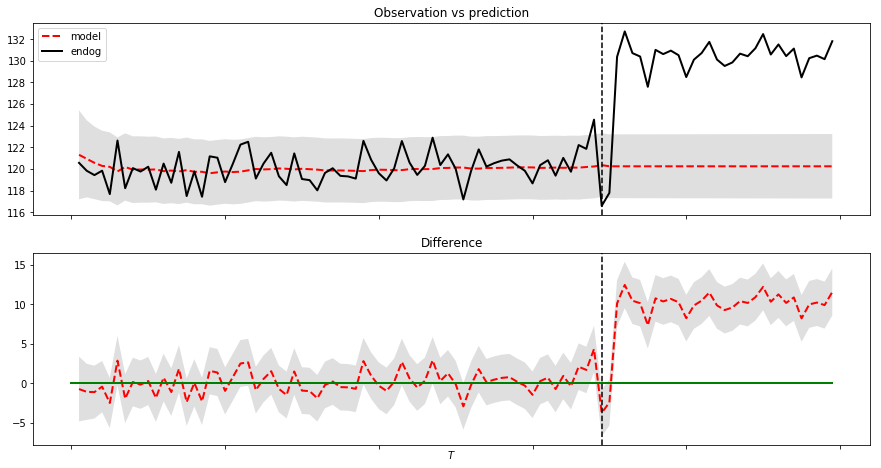

In [32]:
impact.plot(["original", "pointwise"])

This creates a plot without cumulative impact estimates. This is sensible whenever the response variable represents a stock quantity that cannot be meaningfully summed up across time (e.g., number of current subscribers), rather than a flow quantity (e.g., number of clicks).

### How can I obtain 90% intervals instead of 95% intervals?
The size of the intervals is specified by the argument alpha, which defaults to 0.05. To obtain 90% intervals instead, we would use:

In [33]:
impact = CausalImpact(data, pre_period, post_period, alpha = 0.1)